This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2025.1_tutorials/wallaroo-run-anywhere/observability/edge-observability-assays).

## Wallaroo Edge Observability with Assays Tutorial

This notebook is designed to demonstrate the Wallaroo Edge Observability with Wallaroo Assays.  This notebook will walk through the process of:

* In Wallaroo Ops:
  * Setting up a workspace, pipeline, and model for deriving the price of a house based on inputs.
  * Creating an assay from a sample of inferences.
  * Display the inference result and upload the assay to the Wallaroo instance where it can be referenced later.
* In a remote aka edge location:
  * Deploying the Wallaroo pipeline as a Wallaroo Inference Server deployed on an edge device with observability features.
* In Wallaroo Ops:
  * Updating the assay to use the edge location's inferences for assays.

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

## Prerequisites

* A deployed Wallaroo Ops instance.
* A location with Docker or Kubernetes with `helm` for Wallaroo Inference server deployments.
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame

## References

* [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/)

In [1]:
workspace_name = f'edge-observability'
main_pipeline_name = 'houseprice-estimation-edge'
model_name_control = 'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
edge_name=f"house-price-edge-202502"

## Initial Steps

### Import libraries

The first step is to import the libraries needed for this notebook.

In [2]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import datetime
import time



### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [3]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [4]:
workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)

wl.set_current_workspace(workspace)

{'name': 'edge-observability', 'id': 13, 'archived': False, 'created_by': '1a819833-f4ef-4298-8065-1785a7014681', 'created_at': '2025-07-15T20:27:26.019295+00:00', 'models': [], 'pipelines': []}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [5]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

## Standard Pipeline Steps

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [7]:
mainpipeline = wl.build_pipeline(main_pipeline_name)
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config, wait_for_status=False)

Deployment initiated for houseprice-estimation-edge. Please check pipeline status.


name,houseprice-estimation-edge
created,2025-07-15 20:28:19.370022+00:00
last_updated,2025-07-15 20:28:19.883104+00:00
deployed,True
workspace_id,13
workspace_name,edge-observability
arch,x86
accel,none
tags,
versions,"337078e8-65e5-42a3-b780-f804566d08d9, b79d03bd-9655-4fbc-873c-e1db371ef237"
steps,housepricesagacontrol


In [9]:

time.sleep(15)

while mainpipeline.status()['status'] != 'Running':
    time.sleep(15)
    print("Waiting for deployment.")
    mainpipeline.status()['status']
mainpipeline.status()['status']


Waiting for deployment.
Waiting for deployment.


'Running'

### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around `$700k`, the other with a house determined to be around `$1.5` million.  We'll also save the start and end periods for these events to for later log functionality.

In [11]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,anomaly.count
0,2025-07-15 20:29:45.331,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [12]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,anomaly.count
0,2025-07-15 20:29:46.452,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


## Assays

Wallaroo assays provide a method for detecting input or model drift.  These can be triggered either when unexpected input is provided for the inference, or when the model needs to be retrained from changing environment conditions.

Wallaroo assays can track either an input field and its index, or an output field and its index.  For full details, see the [Wallaroo Assays Management Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

For this example, we will:

* Perform sample inferences based on lower priced houses.
* Create an assay with the baseline set off those lower priced houses.
* Generate inferences spread across all house values, plus specific set of high priced houses to trigger the assay alert.
* Run an interactive assay to show the detection of values outside the established baseline.

### Assay Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline. Assays are typically run on a 24 hours interval based on a 24 hour window of data, but we'll bypass that by setting our baseline time even shorter.

In [13]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 30 seconds to set this data apart from the rest
time.sleep(30)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

In [14]:
display(small_results)

,time,in.tensor,out.variable,anomaly.count
0,2025-07-15 20:30:18.491,"[2.0, 1.0, 770.0, 5040.0, 1.0, 0.0, 0.0, 3.0, 5.0, 770.0, 0.0, 47.5964012146, -122.2990036011, 1330.0, 2580.0, 85.0, 0.0, 0.0]",[448627.8],0
1,2025-07-15 20:30:18.491,"[2.0, 1.0, 1070.0, 8130.0, 1.0, 0.0, 0.0, 3.0, 7.0, 1070.0, 0.0, 47.6969985962, -122.3700027466, 1360.0, 7653.0, 73.0, 0.0, 0.0]",[403520.16],0
2,2025-07-15 20:30:18.491,"[3.0, 2.25, 2390.0, 7875.0, 1.0, 0.0, 1.0, 3.0, 10.0, 1980.0, 410.0, 47.6515007019, -122.2779998779, 3720.0, 9075.0, 66.0, 0.0, 0.0]",[1364149.9],0
3,2025-07-15 20:30:18.491,"[3.0, 2.5, 1740.0, 30886.0, 2.0, 0.0, 0.0, 3.0, 8.0, 1740.0, 0.0, 47.4599990845, -121.7070007324, 1740.0, 39133.0, 22.0, 0.0, 0.0]",[306037.63],0
4,2025-07-15 20:30:18.491,"[4.0, 2.5, 3710.0, 7491.0, 2.0, 0.0, 0.0, 3.0, 9.0, 3710.0, 0.0, 47.5596008301, -122.0159988403, 3040.0, 7491.0, 12.0, 0.0, 0.0]",[879092.9],0
...,...,...,...,...
495,2025-07-15 20:30:18.491,"[3.0, 2.0, 1310.0, 9855.0, 1.0, 0.0, 0.0, 3.0, 7.0, 1310.0, 0.0, 47.729598999, -122.2409973145, 1310.0, 8370.0, 52.0, 0.0, 0.0]",[340764.53],0
496,2025-07-15 20:30:18.491,"[4.0, 2.75, 2020.0, 7070.0, 1.0, 0.0, 0.0, 5.0, 7.0, 1010.0, 1010.0, 47.520198822, -122.3779983521, 1390.0, 6000.0, 56.0, 0.0, 0.0]",[379752.2],0
497,2025-07-15 20:30:18.491,"[4.0, 1.0, 1330.0, 2400.0, 1.5, 0.0, 0.0, 4.0, 6.0, 1330.0, 0.0, 47.6500015259, -122.3399963379, 1330.0, 4400.0, 114.0, 0.0, 0.0]",[448627.8],0
498,2025-07-15 20:30:18.491,"[4.0, 2.25, 1920.0, 8259.0, 2.0, 0.0, 0.0, 4.0, 8.0, 1920.0, 0.0, 47.5615997314, -122.0879974365, 2030.0, 8910.0, 35.0, 0.0, 0.0]",[553463.25],0


### Derive Numpy Values

For our assay, we will create it using the inference results and collect them into one numpy array.

In [15]:
# get the numpy values

# set the results to a non-array value
small_results_baseline_df = small_results.copy()
small_results_baseline_df['variable']=small_results['out.variable'].map(lambda x: x[0])
small_results_baseline_df

,time,in.tensor,out.variable,anomaly.count,variable
0,2025-07-15 20:30:18.491,"[2.0, 1.0, 770.0, 5040.0, 1.0, 0.0, 0.0, 3.0, 5.0, 770.0, 0.0, 47.5964012146, -122.2990036011, 1330.0, 2580.0, 85.0, 0.0, 0.0]",[448627.8],0,448627.80
1,2025-07-15 20:30:18.491,"[2.0, 1.0, 1070.0, 8130.0, 1.0, 0.0, 0.0, 3.0, 7.0, 1070.0, 0.0, 47.6969985962, -122.3700027466, 1360.0, 7653.0, 73.0, 0.0, 0.0]",[403520.16],0,403520.16
2,2025-07-15 20:30:18.491,"[3.0, 2.25, 2390.0, 7875.0, 1.0, 0.0, 1.0, 3.0, 10.0, 1980.0, 410.0, 47.6515007019, -122.2779998779, 3720.0, 9075.0, 66.0, 0.0, 0.0]",[1364149.9],0,1364149.90
3,2025-07-15 20:30:18.491,"[3.0, 2.5, 1740.0, 30886.0, 2.0, 0.0, 0.0, 3.0, 8.0, 1740.0, 0.0, 47.4599990845, -121.7070007324, 1740.0, 39133.0, 22.0, 0.0, 0.0]",[306037.63],0,306037.63
4,2025-07-15 20:30:18.491,"[4.0, 2.5, 3710.0, 7491.0, 2.0, 0.0, 0.0, 3.0, 9.0, 3710.0, 0.0, 47.5596008301, -122.0159988403, 3040.0, 7491.0, 12.0, 0.0, 0.0]",[879092.9],0,879092.90
...,...,...,...,...,...
495,2025-07-15 20:30:18.491,"[3.0, 2.0, 1310.0, 9855.0, 1.0, 0.0, 0.0, 3.0, 7.0, 1310.0, 0.0, 47.729598999, -122.2409973145, 1310.0, 8370.0, 52.0, 0.0, 0.0]",[340764.53],0,340764.53
496,2025-07-15 20:30:18.491,"[4.0, 2.75, 2020.0, 7070.0, 1.0, 0.0, 0.0, 5.0, 7.0, 1010.0, 1010.0, 47.520198822, -122.3779983521, 1390.0, 6000.0, 56.0, 0.0, 0.0]",[379752.2],0,379752.20
497,2025-07-15 20:30:18.491,"[4.0, 1.0, 1330.0, 2400.0, 1.5, 0.0, 0.0, 4.0, 6.0, 1330.0, 0.0, 47.6500015259, -122.3399963379, 1330.0, 4400.0, 114.0, 0.0, 0.0]",[448627.8],0,448627.80
498,2025-07-15 20:30:18.491,"[4.0, 2.25, 1920.0, 8259.0, 2.0, 0.0, 0.0, 4.0, 8.0, 1920.0, 0.0, 47.5615997314, -122.0879974365, 2030.0, 8910.0, 35.0, 0.0, 0.0]",[553463.25],0,553463.25


In [16]:
# get the numpy values
small_results_baseline = small_results_baseline_df['variable'].to_numpy()
small_results_baseline

array([ 448627.8 ,  403520.16, 1364149.9 ,  306037.63,  879092.9 ,
       1489624.3 ,  879092.9 ,  886958.6 ,  379398.28,  675545.44,
        437177.97,  551223.44,  261886.94,  284336.47,  682284.56,
        418823.38,  701940.7 ,  732735.94,  557391.25,  453195.8 ,
        368504.3 ,  461279.1 ,  519346.94,  732735.94,  450867.7 ,
        438346.38,  424966.6 ,  340764.53,  335398.94,  879092.9 ,
        557391.25,  726181.75, 1160512.8 ,  242591.38,  553463.25,
        716173.94,  281823.13,  349102.75,  682284.56,  239734.08,
        260603.88,  243300.83,  246901.14,  563844.44,  340764.53,
        437177.97,  546631.94,  464060.2 ,  313096.  ,  723934.9 ,
        450867.7 ,  350835.9 ,  630865.5 ,  317765.63,  400561.2 ,
        437177.97,  675545.44,  581002.94,  291857.06,  448627.8 ,
        453195.8 ,  447192.22,  416617.38,  772048.1 ,  383833.88,
        243585.28,  827411.25,  757403.4 ,  340764.53,  757403.4 ,
        530288.94,  448627.8 ,  438346.38,  310992.94,  236815

### Create Assay from Numpy Values

Assays are created with the `wallaroo.client.build_assay` method.  We provide the following parameters:

* The **unique** name of the assay
* The pipeline
* The name of the model to track inference data from
* The model name
* The iopath (the fields output by the model to track)
* The baseline data - our derived numpy array.

In [17]:
assay_baseline_from_numpy_name = "assays from numpy for edge"

# assay builder by baseline
assay_builder_from_numpy = wl.build_assay(assay_name=assay_baseline_from_numpy_name, 
                               pipeline=mainpipeline, 
                               model_name=model_name_control, 
                               iopath="output variable 0", 
                               baseline_data = small_results_baseline)

We'll display the histogram of the current baseline, which came directly from the previous inference results.

In [21]:
assay_builder_from_numpy.window_builder().add_width(minutes=1)
assay_builder_from_numpy.window_builder().add_start(assay_baseline_start)
assay_builder_from_numpy.add_run_until(datetime.datetime.now())

In [22]:
assay_config_from_numpy = assay_builder_from_numpy.build()

In [23]:
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

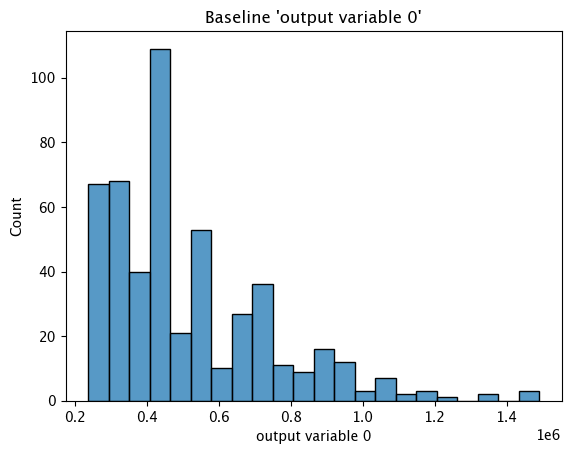

In [24]:
# get the histogram from the numpy baseline
assay_builder_from_numpy.baseline_histogram()

### Assay Testing

Now we'll perform some inferences with a spread of values, then a larger set with a set of larger house values to trigger our assay alert.  We'll use our assay created from the numpy baseline values to demonstrate.

Because our assay windows are 1 minutes, we'll need to stagger our inference values to be set into the proper windows.  This will take about 4 minutes.

In [25]:
# Get a spread of house values

# Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

time.sleep(35)
regular_houses_inputs = pd.read_json('./data/xtest-1k.df.json', orient="records")
inference_size = 1000

regular_houses = regular_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

# And a spread of large house values

time.sleep(65)
big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)



mainpipeline.infer(big_houses)


# End our assay window period
assay_window_end = datetime.datetime.now()

### Assay Configuration

Because we are using a short amount of data, we'll shorten the window and interval to just 1 minute each, and narrow the window to when we started our set of inferences to when we finish.

In [26]:
assay_builder_from_numpy.add_run_until(assay_window_end)
assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_numpy.build()
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

Generated 1 analyses


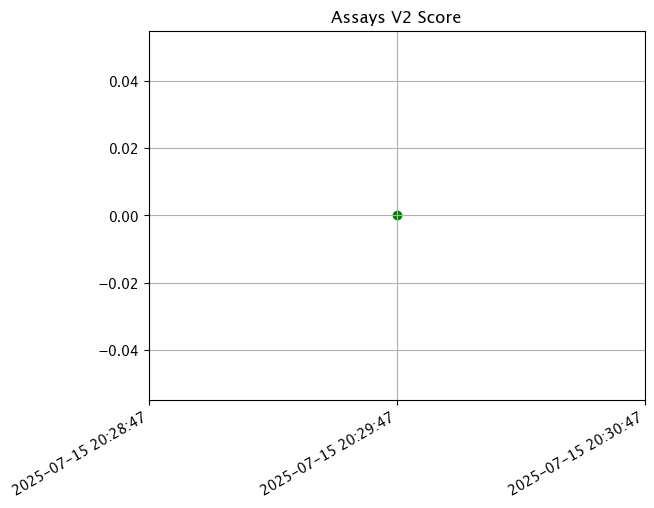

In [27]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_numpy)} analyses")
assay_analysis_from_numpy.chart_scores()

In [28]:
# Display the results as a DataFrame - we're mainly interested in the score and whether the 
# alert threshold was triggered
display(assay_analysis_from_numpy.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,0.0,2025-07-15 20:29:47.982098+00:00,0.25,Ok


### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [29]:
mainpipeline.undeploy()

name,houseprice-estimation-edge
created,2025-07-15 20:28:19.370022+00:00
last_updated,2025-07-15 20:28:19.883104+00:00
deployed,False
workspace_id,13
workspace_name,edge-observability
arch,x86
accel,none
tags,
versions,"337078e8-65e5-42a3-b780-f804566d08d9, b79d03bd-9655-4fbc-873c-e1db371ef237"
steps,housepricesagacontrol


## Edge Deployment

We can now deploy the pipeline to an edge device.  This will require the following steps:

* Publish the pipeline:  Publishes the pipeline to the OCI registry.
* Add Edge:  Add the edge location to the pipeline publish.
* Deploy Edge:  Deploy the edge device with the edge location settings.

### Publish Pipeline

Publishing the pipeline uses the pipeline `publish()` command, which returns the OCI registry information.

In [30]:
assay_pub = mainpipeline.publish()

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is publishing..... Published.


### Add Edge

The edge location is added with the `publish.add_edge(name)` method.  This returns the OCI registration information, and the `EDGE_BUNDLE` information.  The `EDGE_BUNDLE` data is a base64 encoded set of parameters for the pipeline that the edge device is associated with.

In [31]:
display(edge_name)
edge_publish = assay_pub.add_edge(edge_name)
display(edge_publish)

'house-price-edge-202502'

ID,2
Pipeline Name,houseprice-estimation-edge
Pipeline Version,8d289f8d-a4c9-4114-80ba-f1704cbfbb96
Status,Published
Workspace Id,13
Workspace Name,edge-observability
Edges,house-price-edge-202502
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2025.1.0-6250
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/houseprice-estimation-edge:8d289f8d-a4c9-4114-80ba-f1704cbfbb96
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/houseprice-estimation-edge
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:1eead3da7f4c8b7d50823e97f0934138b55585d38978bd4e72202224e675fcd0


### DevOps Deployment

The edge deployment is performed with `docker run`, `docker compose`, or `helm` installations.  The following command generates the `docker run` command, with the following values provided by the DevOps Engineer:

* `$EDGE_PORT`
* `$OCI_USERNAME`
* `$OCI_PASSWORD`
* `PERSISTENT_VOLUME_DIR`

### Verify Logs

Before we perform inferences on the edge deployment, we'll collect the pipeline logs and display the current partitions.  These should only include the Wallaroo Ops pipeline.

In [32]:
logs = mainpipeline.logs(dataset=['time', 'out.variable', 'metadata'])

ops_locations = [pd.unique(logs['metadata.partition']).tolist()][0]
display(ops_locations)
ops_location = ops_locations[0]

['engine-76f8b948d9-2s4nf']

### Edge Inferences

We will perform sample inference on our edge location, then verify that the inference results are added to our pipeline logs with the name of our edge location.  For these example, the edge location is on the hostname `testboy.local`.

In [34]:
edge_datetime_start = datetime.datetime.now()

!curl testboy.local:8081/pipelines

{"pipelines":[{"id":"houseprice-estimation-edge","version":"8d289f8d-a4c9-4114-80ba-f1704cbfbb96","status":"Running"}]}

In [35]:
!curl -X POST testboy.local:8081/pipelines/{main_pipeline_name} \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data @./data/xtest-1k.df.json

[{"time":1752611931577,"in":{"tensor":[4.0,2.5,2900.0,5505.0,2.0,0.0,0.0,3.0,8.0,2900.0,0.0,47.6063,-122.02,2970.0,5251.0,12.0,0.0,0.0]},"out":{"variable":[718013.75]},"anomaly":{"count":0},"metadata":{"last_model":"{\"model_name\":\"housepricesagacontrol\",\"model_sha\":\"e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6\"}","pipeline_version":"8d289f8d-a4c9-4114-80ba-f1704cbfbb96","elapsed":[7264534,9977598],"dropped":[],"partition":"house-price-edge-202502"}},{"time":1752611931577,"in":{"tensor":[2.0,2.5,2170.0,6361.0,1.0,0.0,2.0,3.0,8.0,2170.0,0.0,47.7109,-122.017,2310.0,7419.0,6.0,0.0,0.0]},"out":{"variable":[615094.56]},"anomaly":{"count":0},"metadata":{"last_model":"{\"model_name\":\"housepricesagacontrol\",\"model_sha\":\"e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6\"}","pipeline_version":"8d289f8d-a4c9-4114-80ba-f1704cbfbb96","elapsed":[7264534,9977598],"dropped":[],"partition":"house-price-edge-202502"}},{"time":1752611931577,"in":{"tensor":

In [36]:
time.sleep(10)

edge_datetime_end = datetime.datetime.now()

logs = mainpipeline.logs(start_datetime = edge_datetime_start,
                        end_datetime = edge_datetime_end,
                        dataset=['time', 'out.variable', 'metadata'])

edge_locations = [pd.unique(logs['metadata.partition']).tolist()][0]
print(edge_locations)

['house-price-edge-202502']


## Edge Observability

We can now update our assay to include separate edge locations and display the results using the `wallaroo.assay_config.AssayBuilder.window_builder.add_location_filter()`.  We'll start by just including our Wallaroo Ops pipeline, with the dates limited to the start of of the Ops Pipeline inferences to include the edge inference results.

In [37]:
assay_builder_from_numpy.add_run_until(edge_datetime_end)
assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start).add_location_filter([ops_location])
assay_config_from_numpy = assay_builder_from_numpy.build()
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

Generated 1 analyses


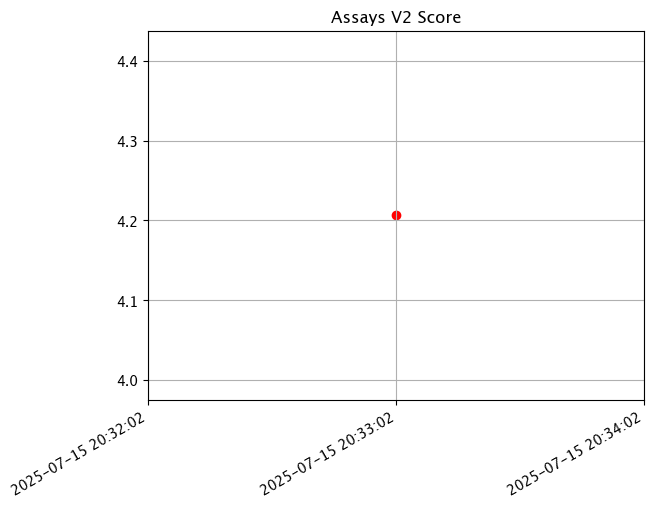

In [38]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_numpy)} analyses")
assay_analysis_from_numpy.chart_scores()

Now we'll update with for just the edge location.

In [39]:
assay_builder_from_numpy.add_run_until(edge_datetime_end)
(assay_builder_from_numpy
    .window_builder()
    .add_width(minutes=1)
    .add_interval(minutes=1)
    .add_start(assay_window_start)
    .add_location_filter([edge_name]))
assay_config_from_numpy = assay_builder_from_numpy.build()
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

Generated 1 analyses


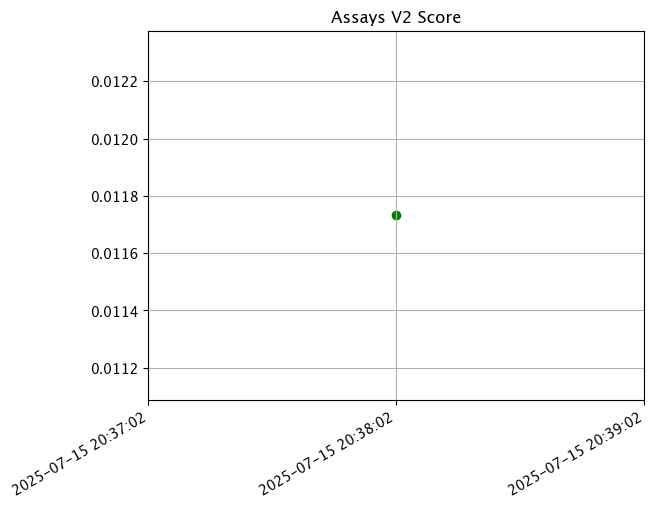

In [40]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_numpy)} analyses")
assay_analysis_from_numpy.chart_scores()

And finally we will use both locations in a cumulative assay window.

In [41]:
assay_builder_from_numpy.add_run_until(edge_datetime_end)
(assay_builder_from_numpy
    .window_builder()
    .add_width(minutes=1)
    .add_interval(minutes=1)
    .add_start(assay_window_start)
    .add_location_filter([ops_location, edge_name]))
assay_config_from_numpy = assay_builder_from_numpy.build()
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

Generated 2 analyses


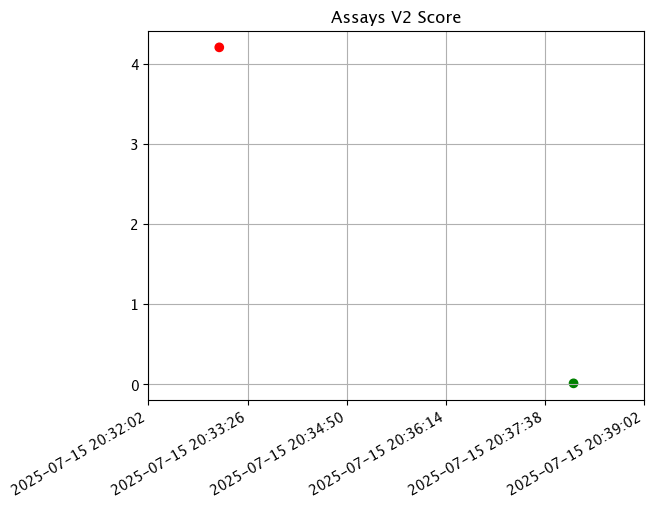

In [42]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_numpy)} analyses")
assay_analysis_from_numpy.chart_scores()